# Detecting open doors using object detection
This notebooks uses an RTSP camera to acquire images and send them to LandngLens for analysis

In [1]:
#@title Set the following variables as needed for your setup
api_key         = "dvkyqd942h90wn1t3fsbjshsud3xdgs"  #@param {type:"string"}
api_secret      = "gj95e8antnkhcduuwrgok3efrtwpzqojykc05l8yiuxnaecxdqxvawrir0d3yw"  #@param {type:"string"}
# In order to find the URL for your camera, this is a good start https://www.ispyconnect.com/cameras
camera_url      =  "rtsp://172.25.101.151/ch0_0.h264" #@param {type:"string"}
# camera_url      =  './sample_images/door_%02d.jpg' # Use sample images
# camera_url      =  0 # Connect to local webcam
model_endpoint  =  "c0791de7-66e3-4970-9a87-064e5e3b07ee" #@param {type:"string"}

In [2]:
# Load LandingLens library from the local repo
import sys, os
sys.path.append("../..")

## Acquire image from camera

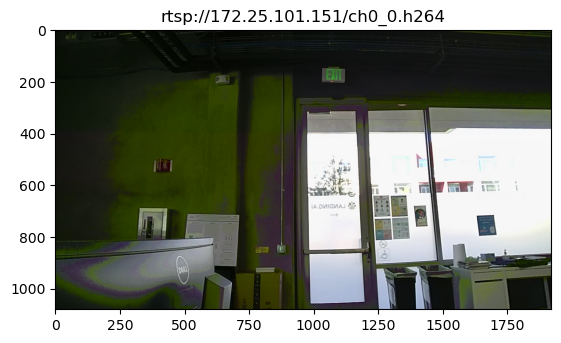

In [3]:
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image

# Open connection to camera
vcap = cv2.VideoCapture(camera_url)

# Capture frame-by-frame
ret, frame = vcap.read()

# Convert color space to RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show the captured image
plt.imshow(frame)
plt.title(camera_url)
plt.show()

## Run the object detection model on LandingLens cloud

In [5]:
from landingai.predict import Predictor
from landingai.visualize import overlay_predictions
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[ObjectDetectionPrediction(id='f666734c-598c-4f7d-9361-62d507885651', score=0.8781492710113525, label_name='Closed', label_index=2, bboxes=(923, 273, 1236, 1068))]

## Visualize results

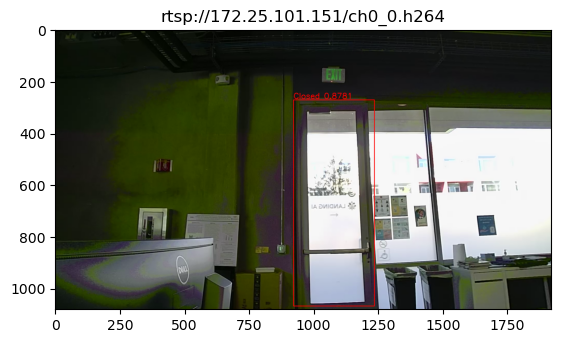

In [6]:
# Draw raw results on the original image
frame = overlay_predictions(results, image=frame)
plt.imshow(frame)
plt.title(camera_url)
plt.show()


## Process results to determine if the door is open or closed

In [8]:
from IPython.display import display, Markdown
# For better accuracy we look at the top detection and only claim that hte door is closed if we identify it as such. If the door is partially open or fully open it will be reported as open
top_detection = max(results, key=lambda x: x.score)
if top_detection.label_name == "Closed":
    display(Markdown('# The door is not open'))
else:
    display(Markdown('# The door is open'))


# The door is not open